# Question 2: CMS Account - Savannah Sew-Hee
The CMS collaboration has an automated job submission system that runs jobs as "cmslocal" and "cmspilot".

For these two users, jobs have internal system tests that will terminate their jobs early after approximately 30 minutes.

Do any of their jobs that ended in under an hour also cluster on specific compute nodes, 
suggesting possbily unreliable systems? 

Check both “production” and “nogpfs” partitions. 

Look for commonly failing nodes and compare with other failed jobs.
_____________________________________________________________________________

In [55]:
import numpy as np 
import pandas as pd 
import re
from io import StringIO
from datetime import time

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)

In [56]:
# reformat the CSV to use | instead of , to separate rows, then import [a selection] of the data as a dataframe
for_pd = StringIO()
with open('../data/accre-jobs-2020.csv') as accre:
    for line in accre:
        new_line = re.sub(r',', '|', line.rstrip(), count=12)
        print (new_line, file=for_pd)

for_pd.seek(0)

accre_df = pd.read_csv(for_pd, sep='|')#[1000000:1005000] # add this to subset

# Cleaning accre_df

#### Converting time to seconds

In [57]:
#making column for hours:min:sec
accre_df['hours_min_sec_req'] = accre_df['REQTIME'].str[-8:]
accre_df['hours_min_sec_used'] = accre_df['USEDTIME'].str[-8:]

#making column for days
accre_df['day_req'] = accre_df['REQTIME'].str.extract('(.*?)-')
accre_df['day_used'] = accre_df['USEDTIME'].str.extract('(.*?)-')

#filling null rows with zeros
accre_df['day_req'] = accre_df['day_req'].fillna(0)
accre_df['day_used'] = accre_df['day_used'].fillna(0)

# converting to the correct type
accre_df['day_req'] = accre_df['day_req'].astype(int)
accre_df['day_used'] = accre_df['day_used'].astype(int)

In [58]:
#converting to timedelta to then use total_seconds
accre_df['hours_min_sec_req'] =  pd.to_timedelta(accre_df['hours_min_sec_req'], unit='s')
accre_df['hours_min_sec_used'] =  pd.to_timedelta(accre_df['hours_min_sec_used'], unit='s')
accre_df['hours_min_sec_req'] = accre_df['hours_min_sec_req'].dt.total_seconds()
accre_df['hours_min_sec_used'] = accre_df['hours_min_sec_used'].dt.total_seconds()

In [59]:
#making total seconds columns 
accre_df['total_sec_req'] = (accre_df['day_req'] * 86400) + accre_df['hours_min_sec_req']
accre_df['total_sec_used'] = (accre_df['day_used'] * 86400) + accre_df['hours_min_sec_used']

# Cleaning CMS Account Data

In [60]:
#subsetting data for cms account
cms_df = accre_df[accre_df['ACCOUNT']=='cms']

#subsetting data to get rid of debug partition
cms_df = cms_df[cms_df['PARTITION']!='debug']

#subsetting data for only 'cmspilot' and 'cmslocal' users
cms_df = cms_df[(cms_df['USER']=='cmspilot')|(cms_df['USER']=='cmslocal')]

#printing how many CMS jobs including over an hour
print(cms_df.shape)

#subsetting for time under an hour
cms_df = cms_df[cms_df['total_sec_used'] <= 3600]

#getting only failed jobs
#using state != to complete instead of exit code beacuse its built in their code to crash and error might not be reflected in exit code
cms_failed = cms_df[cms_df['STATE'] != 'COMPLETED']
cms_completed = cms_df[cms_df['STATE'] == 'COMPLETED']

(699831, 19)


# EDA and Analysis

In [27]:
#Examining the difference between a 'COMPLETED' job and exitcode '0:0'
pd.crosstab(cms_df['EXITCODE'],cms_df['STATE']).apply(lambda x: (x/x.sum()), axis=1)

STATE,CANCELLED,CANCELLED by 9201,CANCELLED by 9202,COMPLETED,FAILED,RUNNING
EXITCODE,,,,,,
0:0,0.003442,0.000007,0.000007,0.996388,0.000000,0.000157
0:9,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
126:0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
127:0,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
1:0,0.733333,0.000000,0.000000,0.000000,0.266667,0.000000


### How often are jobs canceling around 30 minutes for account CMS?

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D42A211688>]],
      dtype=object)

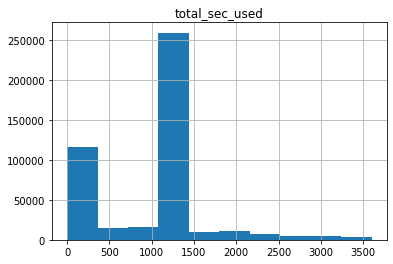

In [61]:
#Looking at distribution of seconds to find spike
#where jobs are canceling sround 30 min
cms_df.hist(column = 'total_sec_used')

In [62]:
#How many jobs ended between 500 and 2000 seconds
#or 1000 and 1500 use this one second spike
cms_jobs_ended_around_30_min = cms_df[(cms_df['total_sec_used'] < 1500) & (cms_df['total_sec_used'] > 1000)]

print("Number of CMS Jobs Total:")
print("(699831, 19)")
print("Number of CMS Jobs Under Hour:")
print(cms_df.shape)
print("Number of CMS Jobs Ended Around 30 Minutes:")
print(cms_jobs_ended_around_30_min.shape)

Number of CMS Jobs Total:
(699831, 19)
Number of CMS Jobs Under Hour:
(447255, 19)
Number of CMS Jobs Ended Around 30 Minutes:
(263645, 19)


In [70]:
#what percent of jobs is this?
print(str(round((263645/699831)*100,2)) + "% are ending around 30 minutes\nout of total CMS jobs (cmspilot/cmslocal users)")
print("\n")
print(str(round((263645/447255)*100,2)) + "% are ending around 30 minutes\nout of jobs ending in less than an hour")

37.67% are ending around 30 minutes
out of total CMS jobs (cmspilot/cmslocal users)


58.95% are ending around 30 minutes
out of jobs ending in less than an hour


### Most Failed Nodes for CMS Account

In [37]:
most_failed_nodes = cms_df['NODELIST'].value_counts().head(20)

Text(0, 0.5, 'Number of Time Failed')

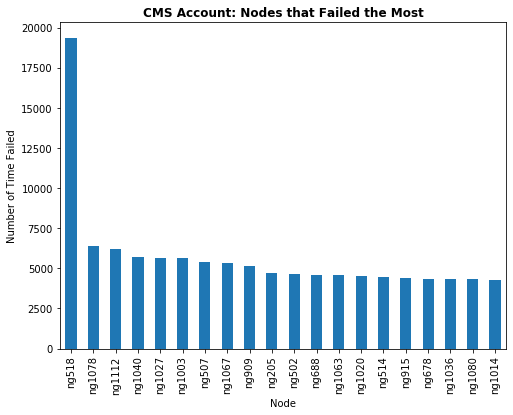

In [38]:
ax = most_failed_nodes.plot(kind = 'bar', figsize = (8,6))
ax.set_title('CMS Account: Nodes that Failed the Most',weight='bold', size='large')
ax.set_xlabel('Node')
ax.set_ylabel('Number of Time Failed')

In [39]:
most_failed_nodes.head(10)

ng518     19352
ng1078     6388
ng1112     6171
ng1040     5677
ng1027     5645
ng1003     5629
ng507      5400
ng1067     5357
ng909      5160
ng205      4691
Name: NODELIST, dtype: int64

### Percent of Times that Nodes Failed for CMS Account

In [40]:
#Count of failed nodes for new df for percents
cms_failed['NODELIST'].value_counts().head()

ng518     16
cn1314    12
cn394     11
ng734     10
ng1112     9
Name: NODELIST, dtype: int64

In [41]:
#Count of successful nodes for new df for percents
cms_completed['NODELIST'].value_counts().head()

ng518     19336
ng1078     6382
ng1112     6162
ng1040     5671
ng1027     5640
Name: NODELIST, dtype: int64

In [42]:
#Creating df with top nodes to examine by percent of times failed
CMS_nodes = {'NODE':['ng518','cn1314','cn394','ng734','cn475','cn1094','ng1112','cn449','cn1121','cn304','cn1394','cn408','cn1387','cn399','cn363','cn429','cn1398','cn312'],
            'TIMES_FAILED':[16,12,11,10,9,9,9,9,9,9,8,8,8,8,8,8,8,8],
            'TOTAL_TIMES_USED':[19352,12,347,4138,364,397,6171,400,465,298,408,446,249,415,339,306,550,407]}
CMS_nodes_df = pd.DataFrame(CMS_nodes, columns = ['NODE','TIMES_FAILED','TOTAL_TIMES_USED'])

In [43]:
CMS_nodes_df['PERCENT_FAILED'] = (CMS_nodes_df['TIMES_FAILED']/CMS_nodes_df['TOTAL_TIMES_USED'])*100

Text(0, 0.5, 'Percent of Times Failed')

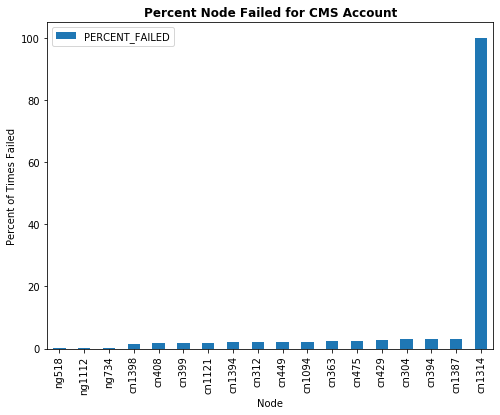

In [39]:
#plotted with one outlier, maybe remove it to make it easier to see
ax = CMS_nodes_df.sort_values('PERCENT_FAILED').plot.bar(x = 'NODE', y = 'PERCENT_FAILED', figsize = (8,6))
ax.set_title('Percent Node Failed for CMS Account',weight='bold', size='large')
ax.set_xlabel('Node')
ax.set_ylabel('Percent of Times Failed')

Text(0, 0.5, 'Percent of Times Failed')

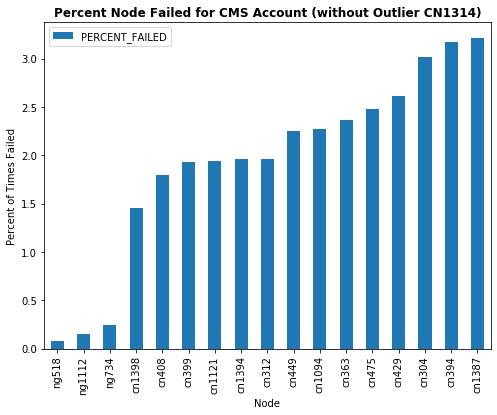

In [44]:
#removed cn 1314 to make it to make it easier to see,  label this graph
CMS_nodes_without_cn1314 = CMS_nodes_df[CMS_nodes_df['NODE'] != 'cn1314']
ax = CMS_nodes_without_cn1314.sort_values('PERCENT_FAILED').plot.bar(x = 'NODE', y = 'PERCENT_FAILED',figsize = (8,6))
ax.set_title('Percent Node Failed for CMS Account (without Outlier CN1314)',weight='bold', size='large')
ax.set_xlabel('Node')
ax.set_ylabel('Percent of Times Failed')

In [71]:
CMS_nodes_df.sort_values('PERCENT_FAILED', ascending = False).head()

,NODE,TIMES_FAILED,TOTAL_TIMES_USED,PERCENT_FAILED
1,cn1314,12,12,100.000000
12,cn1387,8,249,3.212851
2,cn394,11,347,3.170029
9,cn304,9,298,3.020134
15,cn429,8,306,2.614379


# Question 4

In [78]:
# remove unneeded columns
accre = accre_df.drop(["JOBID","USER", "NODELIST"], axis =1) # axis = 1 so that it works across our columns

In [79]:
#new column is for requested memory per node
accre['RMPN'] = accre['REQMEM'].str.extract('(.*)Mn$')

#new column is for requested memory per core
accre['RMPC'] = accre['REQMEM'].str.extract('(.*)Mc$')

#new column is for requested memory per core
accre['UM'] = accre['USEDMEM'].str.extract('(.*)M$')

In [95]:
# change RMPC,RMPN,UM colum to fill with na with 0
accre['RMPC'] = accre['RMPC'].fillna('0')
accre['RMPN'] = accre['RMPN'].fillna('0')
accre['UM'] = accre['UM'].fillna('0')

In [96]:
#fixing types
accre['RMPC']= accre['RMPC'].astype(str).astype(float)
accre['RMPN']= accre['RMPN'].astype(str).astype(float)
accre['UM']= accre['UM'].astype(str).astype(float)

In [98]:
# what is per core??? assume you multiply cpus by node this column will be RMPN times CPUS 
#3.5 is the average node to core ratio
accre['RMPN'] = accre['RMPN'] /(accre['CPUS']/ accre['NODES'])

In [104]:
# what is per core??? update RMPC to add the RMPNEW column
accre['RMPC'] = accre['RMPC'] + accre['RMPN']

# remove unneeded columns
accre = accre.drop(["RMPN"], axis =1)

In [105]:
#convert used memory to cores 
accre['UM'] = (accre['UM'] /accre['CPUS'])/ accre['NODES']

In [110]:
# PERCENT of request to actual used
accre['PRU'] = (accre['UM']/accre['RMPC']) * 100

### Weighted Average

In [113]:
#creating a weighted average function
def wavg(group, avg_name, weight_name):
    """ http://stackoverflow.com/questions/10951341/pandas-dataframe-aggregate-function-using-multiple-columns
    In rare instance, we may not have weights, so just return the mean. Customize this if your business case
    should return otherwise.
    """
    d = group[avg_name]
    w = group[weight_name]
    try:
        return (d * w).sum() / w.sum()
    except ZeroDivisionError:
        return d.mean()

In [114]:
#weighted average for all acounts
wavg(accre, "PRU", "total_sec_used")

15.873373696175483

In [124]:
#weighted average by account (best Optimizing to least)
weighted_mem_accre_accounts = accre.groupby("ACCOUNT").apply(wavg, "PRU", "total_sec_used").sort_values(ascending = False)

In [128]:
# top 10 at optimizing memory
weighted_mem_accre_accounts.head(10)

ACCOUNT
wax            51.983362
carrot         42.386687
cinnabar       37.126888
cep            31.537165
casaba         27.195213
bibb           22.524050
antares        22.416155
blueberries    21.673670
shallots       19.963792
texas          18.709836
dtype: float64

In [130]:
# bottom 10 at optimizing memory
weighted_mem_accre_accounts.tail(10)

ACCOUNT
flamingo     0.0
golden       0.0
florence     0.0
wa           0.0
president    0.0
prince       0.0
hass         0.0
with         0.0
discovery    0.0
pearl        NaN
dtype: float64